# Final ML Model

### Load Training and Testing datasets

In [1]:
import numpy as np
import pandas as pd

#Load all training data
X_train = pd.read_csv('Inputs\\train_test_sets\\training.csv')
y_train = X_train.pop('Label')
print(X_train.shape)

#Load all testing data
X_test = pd.read_csv('Inputs\\train_test_sets\\testing.csv')
y_test = X_test.pop('Label')
print(X_test.shape)

(999856, 71)
(1499016, 71)


In [2]:
print('Shape of Training Set:', X_train.shape)
print('Shape of Testing Set:', X_test.shape)
dist = pd.DataFrame()
dist['y_train Freq'] = y_train.value_counts()
dist['y_train %'] = y_train.value_counts(normalize=True)
dist['y_test Freq'] = y_test.value_counts()
dist['y_test %'] = y_test.value_counts(normalize=True)
dist.style.format("{:.3%}", subset=['y_train %', 'y_test %'])

Shape of Training Set: (999856, 71)
Shape of Testing Set: (1499016, 71)


,y_train Freq,y_train %,y_test Freq,y_test %
Label,,,,
DoS attacks-Hulk,164962,16.499%,115478,7.704%
DDOS attack-HOIC,156456,15.648%,171503,11.441%
DDoS attacks-LOIC-HTTP,151250,15.127%,144048,9.610%
Bot,129813,12.983%,71548,4.773%
Benign,121965,12.198%,847255,56.521%
Infilteration,120476,12.049%,40160,2.679%
SSH-Bruteforce,84521,8.453%,46897,3.129%
DoS attacks-GoldenEye,31131,3.114%,10377,0.692%
FTP-BruteForce,29045,2.905%,48339,3.225%


### Commence Training

#### Undersampling and Oversampling to account for the imbalanced Training Set

In [3]:
from collections import Counter
Counter(y_train)

Counter({'DoS attacks-Hulk': 164962,
         'DDOS attack-HOIC': 156456,
         'DDoS attacks-LOIC-HTTP': 151250,
         'Bot': 129813,
         'Benign': 121965,
         'Infilteration': 120476,
         'SSH-Bruteforce': 84521,
         'DoS attacks-GoldenEye': 31131,
         'FTP-BruteForce': 29045,
         'DoS attacks-Slowloris': 8243,
         'DDOS attack-LOIC-UDP': 1298,
         'Brute Force -Web': 458,
         'Brute Force -XSS': 173,
         'SQL Injection': 65})

In [4]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

#Define the over sampling and under sampling dictionaries
dictUnderSample = { 'DoS attacks-Hulk': 50000,
                    'DDOS attack-HOIC': 50000,
                    'DDoS attacks-LOIC-HTTP': 50000,
                    'Bot': 50000,
                    'Benign': 50000,
                    'Infilteration': 50000,
                    'SSH-Bruteforce': 50000,
                    'DoS attacks-GoldenEye': 31131,
                    'FTP-BruteForce': 29045,
                    'DoS attacks-Slowloris': 8243,
                    'DDOS attack-LOIC-UDP': 1298,
                    'Brute Force -Web': 458,
                    'Brute Force -XSS': 173,
                    'SQL Injection': 65}

dictOverSample = {  'DoS attacks-Hulk': 50000,
                    'DDOS attack-HOIC': 50000,
                    'DDoS attacks-LOIC-HTTP': 50000,
                    'Bot': 50000,
                    'Benign': 50000,
                    'Infilteration': 50000,
                    'SSH-Bruteforce': 50000,
                    'DoS attacks-GoldenEye': 50000,
                    'FTP-BruteForce': 50000,
                    'DoS attacks-Slowloris': 50000,
                    'DDOS attack-LOIC-UDP': 50000,
                    'Brute Force -Web': 50000,
                    'Brute Force -XSS': 50000,
                    'SQL Injection': 50000}

#Pipeline for undersampling and then oversampling
pipeline = Pipeline(steps=[ ('underSample', RandomUnderSampler(random_state=0, sampling_strategy=dictUnderSample)),
                            ('overSample', BorderlineSMOTE(random_state=0, sampling_strategy=dictOverSample)) ])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)
print(len(X_train2))
y_train2.value_counts()

679045


Label
Benign                    50000
Bot                       50000
Brute Force -Web          50000
Brute Force -XSS          50000
DDOS attack-HOIC          50000
DDOS attack-LOIC-UDP      50000
DDoS attacks-LOIC-HTTP    50000
DoS attacks-GoldenEye     50000
DoS attacks-Hulk          50000
DoS attacks-Slowloris     50000
Infilteration             50000
SQL Injection             50000
SSH-Bruteforce            50000
FTP-BruteForce            29045
Name: count, dtype: int64

#### Train the model

Note: The chosen classifier is LGBMClassifier. As this is a tree based classifier, there is not much benefit in using a StandardScaler or a MaxMinScaler to normalise the data. Also, instead of encoding the 2 categorical features in the dataset (Protocol and Dst Port Class), we will simply be removing them altogether - as we discovered towards the end of the Evaluate Models.ipynb, both of these categorical features are not seen as "important" for this classifier. This will greatly simplify the pipeline that is required for training and testing

In [5]:

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
from sklearn.metrics import fbeta_score, matthews_corrcoef
from CustomFunctions import Timer


# Create a pipeline with ColumnTransformer to drop columns
features_to_drop = ['Protocol', 'Dst Port Class', 'Bwd Seg Size Avg', 'CWE Flag Count', 'Fwd Seg Size Avg', 'SYN Flag Cnt', 'Subflow Bwd Pkts', 
                    'Subflow Fwd Pkts']

#Define the main workflow pipeline
workflowPipe = Pipeline(steps=[
                            ('preprocessing', ColumnTransformer(transformers=[('column dropper', 'drop', features_to_drop)], remainder='passthrough')),
                            ('classifier', LGBMClassifier(boosting_type='gbdt', objective='multiclass', n_jobs=-1, verbose=-1,
                                                        n_estimators=100, num_leaves=152, learning_rate=0.1158, max_bin=400,
                                                        bagging_fraction=0.807, bagging_freq=0))
                        ])

#Run the pipeline
t = Timer()
t.start()
workflowPipe.fit(X_train2, y_train2)
t.stop(timerName='Training of model')

c:\Users\Delan\anaconda\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


Training of model took 32.47 seconds (343.09 CPU seconds)


#### Assess model performance

In [6]:
from CustomFunctions import Timer

#Measure the execution performance
t = Timer()
t.start()
pred_test_1000 = workflowPipe.predict(X_test.head(1000))
t.stop('Executing model over the first 1000 rows of Testing Set')

#Obtain predictions on the full Training dataset
pred_train = workflowPipe.predict(X_train)

#Obtain predictions on the full Testing dataset
t.start()
pred_test = workflowPipe.predict(X_test)
t.stop('Executing model over the entire Testing set (' + str(len(X_test)) + ') rows')


Executing model over the first 1000 rows of Testing Set took 0.03 seconds (0.25 CPU seconds)
Executing model over the entire Testing set (1499016) rows took 21.29 seconds (212.14 CPU seconds)



Training Set: Size:  (999856, 71)
Training Set: F2 score:  0.9835261623723025
Training Set: Matthews Correlation Coefficient:  0.9805038011616085

Testing Set: Size:  (1499016, 71)
Testing Set: F2 score:  0.9142067882863197
Testing Set: Matthews Correlation Coefficient:  0.9105556798515417


                        precision  recall  f2-score  support
Benign                       1.00    0.89      0.91  847,255
Bot                          1.00    1.00      1.00   71,548
Brute Force -Web             0.36    0.92      0.70      153
Brute Force -XSS             0.79    0.95      0.91       57
DDOS attack-HOIC             1.00    1.00      1.00  171,503
DDOS attack-LOIC-UDP         0.72    0.99      0.92      432
DDoS attacks-LOIC-HTTP       1.00    1.00      1.00  144,048
DoS attacks-GoldenEye        1.00    1.00      1.00   10,377
DoS attacks-Hulk             1.00    1.00      1.00  115,478
DoS attacks-Slowloris        0.99    1.00      1.00    2,747
FTP-BruteForce               1.00  

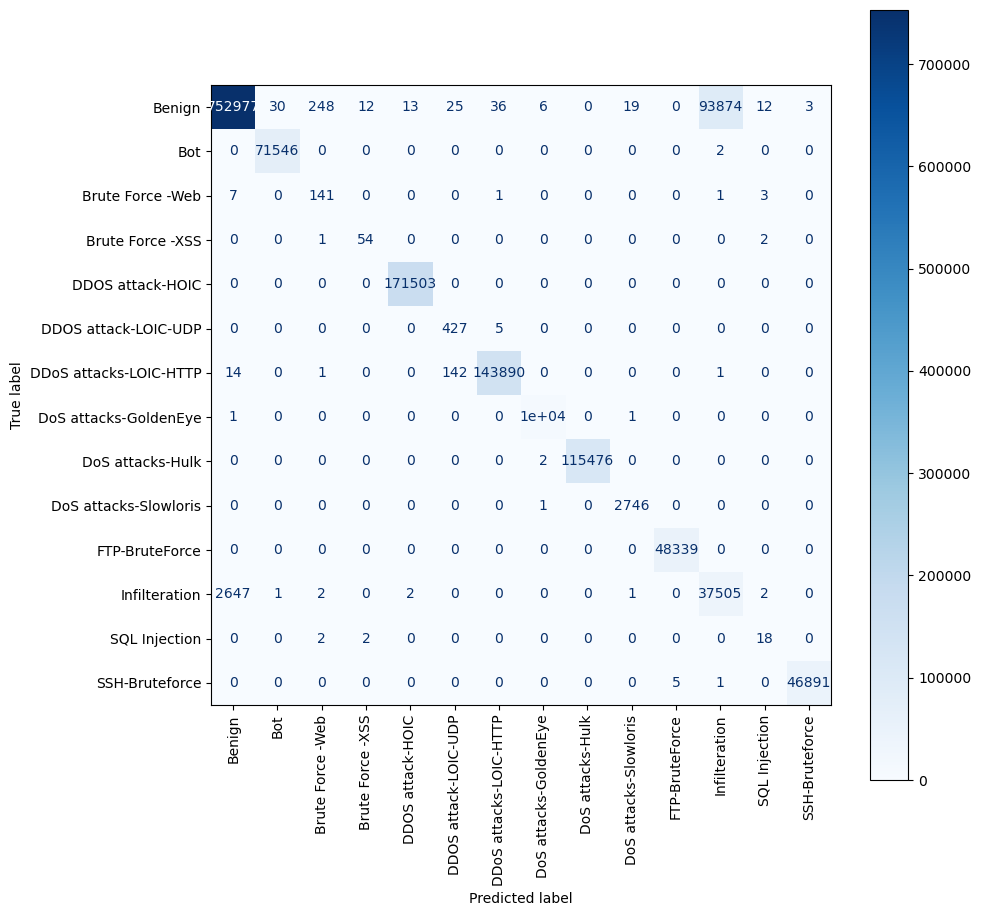

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from CustomFunctions import classification_report_IDS

#Output results
print('\nTraining Set: Size: ', X_train.shape)
print('Training Set: F2 score: ', fbeta_score(y_train, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))
print('\n')

#Plot the confusion matrix
c = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_test), display_labels=workflowPipe.classes_)
fig, ax = plt.subplots(figsize=(10,10))
c.plot(ax = ax, cmap='Blues', xticks_rotation='vertical')

## Classification Report
classification_report_IDS(y_test, pred_test)